In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [276]:
def cap_table_function(investors, series, shares, options_holders, options_class, options):
    
    #cap table init
    shares_data = []
    options_data = []
    
    for i in range (len(investors)):
        add = shares[i] + len(options_class)*[0]
        shares_data.append(add)
    
    for i in range (len(options_holders)):
        add = len(series)*[0] + options[i]
        options_data.append(add)
        
    data = shares_data + options_data
    index_list = investors + options_holders
    columns_list = series + options_class
    
    cap_table = pd.DataFrame(data, index = index_list, columns = columns_list)
    
    #Add columns total NFD and FD
    cap_table.insert(len(series), "Total NFD", cap_table[series].sum(axis=1))
    cap_table.insert(len(columns_list)+1, "Total FD", cap_table[columns_list].sum(axis=1))
    columns_list.append("Total NFD")
    columns_list.append("Total FD")
    
    #Columns total
    for i in range (len(columns_list)):
        cap_table.loc["Total", columns_list[i]] = cap_table[columns_list[i]].sum()
        
    #% column
    cap_table.insert(len(series)+1, "Total NFD (%)", cap_table["Total NFD"] / cap_table.at["Total", "Total NFD"])
    cap_table.insert(len(columns_list)+1, "Total FD (%)", cap_table["Total FD"] / cap_table.at["Total", "Total FD"])
        
    #format
    format_dict = { i : '{:,.0f}'.format for i in list(cap_table.columns) }
    format_dict["Total NFD (%)"] = '{:,.2%}'.format
    format_dict["Total FD (%)"] = '{:,.2%}'.format

    return (cap_table, cap_table.style.format(format_dict))


def liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, Galion_rate, multiples_pref, participating, shares_prices, sale_price):
    
    first_step_item = first_step + (first_step == "Galion")*(": " + str(Galion_rate) + "%")
        
    liquid_pref_steps = [first_step_item]
    for i in range (len(series)-1):
        add = series[-1-i].split(' ')[0]
        liquid_pref_steps.append(f"Pref: {add}")
    liquid_pref_steps.append("Prorata")
    liquid_pref_steps
    
    index_list = investors + options_holders

    #liquid pref init
    liquid_pref = pd.DataFrame(index = index_list+["Total"], columns = liquid_pref_steps)
    solde = []
    price_step_list = []


    #First step
    if (first_step == "Nominal"):
        price_step = shares_prices[0]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[0]] = cap_table["Total FD"] * price_step
    elif (first_step == "Galion"):
        price_step = Galion_rate/100 * sale_price / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[0]] = cap_table["Total FD"] * price_step
    else:
        print("ERROR FIRST STEP")
    solde.append(sale_price - liquid_pref.at["Total", liquid_pref_steps[0]])


    #Pref
    for i in range (len(liquid_pref_steps)-2):
        price_step = max(0, multiples_pref[i]*shares_prices[-1-i]-price_step_list[0])
        price_step_list.append(price_step)
        if (solde[-1] >= (cap_table.at["Total", series[-1-i]] * price_step)):
            liquid_pref[liquid_pref_steps[i+1]] = cap_table[series[-1-i]] * price_step
        else:
            liquid_pref[liquid_pref_steps[i+1]] = cap_table[series[-1-i]] * solde[-1] / cap_table.at["Total", series[-1-i]]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[i+1]])

    #prorata
    if (participating):
        price_step = solde[-1] / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[-1]] = cap_table["Total FD (%)"] * solde[-1]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[-1]])
    else:
        initial_liquid_pref_steps_len = len(liquid_pref_steps)
        initial_price_step_list = price_step_list.copy()
        #catchup
        for i in range (initial_liquid_pref_steps_len-2):
            price_step = initial_price_step_list[-1-i] - (i != 0)*initial_price_step_list[-i]
            price_step_list.append(price_step)
            new_column_value = (cap_table.iloc[:, 0:i+1].sum(axis=1)+cap_table.iloc[:, (len(series)+2):(len(series)+2+len(options_class))].sum(axis=1))
            total = (new_column_value*price_step)["Total"] 
            if (solde[-1] >= total):
                liquid_pref.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}", new_column_value*price_step)
            else:
                liquid_pref.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}", new_column_value * solde[-1] / new_column_value["Total"])
            liquid_pref_steps.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}")
            solde.append(solde[-1] - liquid_pref.at["Total", f"Catchup {i+1}"])
        #prorata
        price_step = solde[-1] / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[-1]] = cap_table["Total FD (%)"] * solde[-1]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[-1]])

    #Lines total
    for i in range (len(index_list)):
        liquid_pref.loc[index_list[i], "Total proceeds"] = liquid_pref.loc[index_list[i],].sum()

    #Grand total
    liquid_pref.loc["Total","Total proceeds"] = liquid_pref.loc["Total",].sum()

    #solde + price_step
    for i in range (len(liquid_pref_steps)):
        liquid_pref.loc["Solde", liquid_pref_steps[i]] = solde[i]
        liquid_pref.loc["Prix", liquid_pref_steps[i]] = price_step_list[i] 


    # vs prorata / delta
    for i in range (len(index_list)):
        liquid_pref.loc[index_list[i], "vs prorata"] = cap_table.at[index_list[i], "Total FD (%)"] * sale_price
        liquid_pref.loc[index_list[i], "% delta"] = liquid_pref.at[index_list[i], "Total proceeds"] / liquid_pref.at[index_list[i], "vs prorata"] - 1
    liquid_pref.loc["Total", "vs prorata"] = cap_table.at["Total", "Total FD (%)"] * sale_price
    liquid_pref.loc["Total", "% delta"] = liquid_pref.at["Total", "Total proceeds"] / liquid_pref.at["Total", "vs prorata"] - 1


    #format
    format_dict = { i : '{:,.2f} €'.format for i in list(liquid_pref.columns)}
    format_dict["% delta"] = '{:,.2%}'.format
    liquid_pref.style.format(format_dict)

    return (liquid_pref, liquid_pref.style.format(format_dict))

In [277]:
#input cap table
investors = ['Founders', 'Omnes Capital', 'CM-CIC', 'Cap Decisif', 'Sofinnova', 
             'Bpifrance', 'Valquest', 'EIF', 'M&L', 'BNP', 'Employees']
series = ['Common shares', 'A shares', 'A2 shares', 'B shares']
shares = [
    [115689,0,0,0],
    [0,78947,33334,14816],
    [0,78947,33333,81482],
    [0,52632,22222,5925],
    [0,0,296913,118517],
    [0,0,114196,118517],
    [0,0,0,58525],
    [0,0,0,109629],
    [0,0,0,22224],
    [0,0,0,44445],
    [2081,0,0,0]
    ]
options_holders = ['Options granted', 'Options to grant', 'New options B'] 
options_class = ['A options', 'B options'] 
options = [
    [75452,93500],
    [56081,0],
    [0,22953]
]

cap_table, cap_table_styled = cap_table_function(investors, series, shares, options_holders, options_class, options)
cap_table_styled

,Common shares,A shares,A2 shares,B shares,Total NFD,Total NFD (%),A options,B options,Total FD,Total FD (%)
Founders,"115,689",0,0,0,"115,689",8.25%,0,0,"115,689",7.01%
Omnes Capital,0,"78,947","33,334","14,816","127,097",9.06%,0,0,"127,097",7.70%
CM-CIC,0,"78,947","33,333","81,482","193,762",13.82%,0,0,"193,762",11.74%
Cap Decisif,0,"52,632","22,222","5,925","80,779",5.76%,0,0,"80,779",4.89%
Sofinnova,0,0,"296,913","118,517","415,430",29.62%,0,0,"415,430",25.17%
Bpifrance,0,0,"114,196","118,517","232,713",16.59%,0,0,"232,713",14.10%
Valquest,0,0,0,"58,525","58,525",4.17%,0,0,"58,525",3.55%
EIF,0,0,0,"109,629","109,629",7.82%,0,0,"109,629",6.64%
M&L,0,0,0,"22,224","22,224",1.58%,0,0,"22,224",1.35%
BNP,0,0,0,"44,445","44,445",3.17%,0,0,"44,445",2.69%


In [285]:
#input liquid pref
first_step = "Nominal" # equal Nominal or Galion
Galion_rate = 20
multiples_pref = [1,1,1]
participating = True
shares_prices = [0.1,38,45,67.5]
options_prices = [45, 67.5]
sale_price = 100000000

liquid_pref, liquid_pref_styled = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, Galion_rate, multiples_pref, participating, shares_prices, sale_price)
liquid_pref_styled

,Nominal,Pref: B,Pref: A2,Pref: A,Prorata,Total proceeds,vs prorata,% delta
Founders,"11,568.90 €",0.00 €,0.00 €,0.00 €,"2,152,967.16 €","2,164,536.06 €","7,009,925.11 €",-69.12%
Omnes Capital,"12,709.70 €","998,598.40 €","1,496,696.60 €","2,992,091.30 €","2,365,269.53 €","7,865,365.53 €","7,701,168.23 €",2.13%
CM-CIC,"19,376.20 €","5,491,886.80 €","1,496,651.70 €","2,992,091.30 €","3,605,902.23 €","13,605,908.23 €","11,740,589.93 €",15.89%
Cap Decisif,"8,077.90 €","399,345.00 €","997,767.80 €","1,994,752.80 €","1,503,293.61 €","4,903,237.11 €","4,894,629.05 €",0.18%
Sofinnova,"41,543.00 €","7,988,045.80 €","13,331,393.70 €",0.00 €,"7,731,133.87 €","29,092,116.37 €","25,172,083.67 €",15.57%
Bpifrance,"23,271.30 €","7,988,045.80 €","5,127,400.40 €",0.00 €,"4,330,778.61 €","17,469,496.11 €","14,100,741.66 €",23.89%
Valquest,"5,852.50 €","3,944,585.00 €",0.00 €,0.00 €,"1,089,147.65 €","5,039,585.15 €","3,546,195.98 €",42.11%
EIF,"10,962.90 €","7,388,994.60 €",0.00 €,0.00 €,"2,040,190.83 €","9,440,148.33 €","6,642,732.49 €",42.11%
M&L,"2,222.40 €","1,497,897.60 €",0.00 €,0.00 €,"413,587.65 €","1,913,707.65 €","1,346,615.28 €",42.11%
BNP,"4,444.50 €","2,995,593.00 €",0.00 €,0.00 €,"827,119.48 €","3,827,156.98 €","2,693,048.79 €",42.11%


In [281]:
#export to excel
liquid_pref.to_excel("Liquid_pref.xlsx")

In [142]:
lst = []
lst2 = []
floor = 1000
ceiling = 40000
step = 1000

for i in range (floor, ceiling+step, step):
    a,b = liquid_pref_function(i)
    lst.append(a["Total proceeds"]["Omnes Capital"])
    lst2.append(a["Total proceeds"]["Founders"])

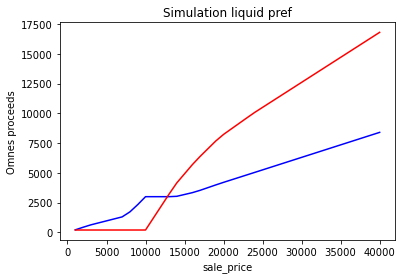

In [143]:
x=range (floor, ceiling+step, step)
y=lst
y2=lst2

plt.plot(x,y,linestyle='solid',color='blue')
plt.plot(x,y2,linestyle='solid',color='red')
plt.title("Simulation liquid pref")
plt.xlabel("sale_price")
plt.ylabel("Omnes proceeds")
plt.show()

In [ ]:
### A ajouter
    # options (déclenchement, ...)
    # Graphe
    # Interface user
    # data table

In [173]:
series = ['Common shares', 'A shares', 'A2 shares', 'B shares'] + []
len(series)

4

In [199]:
series+options_class

['Common shares',
 'A shares',
 'A2 shares',
 'B shares',
 'A options',
 'B options']